# Project for an online shop to detect toxic comments


The Wikishop online store is launching a new service. Now users can edit and add product descriptions, just like in wiki communities. That is, clients propose their own edits and comment on the changes of others. The store needs a tool that will look for toxic comments and send them for moderation.

Train the model to classify comments into positive and negative. At your disposal is a set of data with markings about the toxicity of edits.

Build a model with a quality metric value *F1* of at least 0.75.

**Instructions for completing the project**

1. Download and prepare data.
2. Train different models.
3. Draw conclusions.

It is not necessary to use *BERT* to complete the project, but you can try.

**Description of data**

The data is in the file `toxic_comments.csv`. The *text* column in it contains the text of the comment, and *toxic* is the target attribute.

## Preparation

In [1]:
import numpy as np
import pandas as pd
import re
import torch
import transformers
from tqdm import notebook
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from pymystem3 import Mystem
m = Mystem()


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer


from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Let's remove the 'Unnamed: 0' column, it only repeats the indexes.

In [4]:
df = df.drop('Unnamed: 0', axis = 1)


Let's look separately at toxic and non-toxic comments and their lengths:

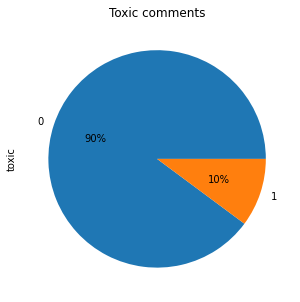

In [5]:
df['toxic'].value_counts().plot(
    kind='pie', 
    figsize=(10, 5), 
    legend=False, 
    title='Toxic comments', 
    autopct='%1.0f%%'
)
plt.show()

90% non-toxic comments, imbalance will need to be taken into account.

In [ ]:
df_toxic = df.query('toxic ==1')
df_toxic['text'].str.len().hist(bins= 50)
plt.title('Length of toxic comments')

count    16186.000000
mean       302.932411
std        618.647890
min          5.000000
25%         61.000000
50%        128.000000
75%        282.750000
max       5000.000000
Name: text, dtype: float64

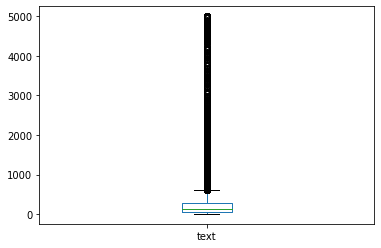

In [7]:
ax = df_toxic['text'].str.len().plot.box()
df_toxic['text'].str.len().describe()

In [ ]:
df_nontoxic = df.query('toxic ==0')
df_nontoxic['text'].str.len().hist(bins= 50)
plt.title('Length of non toxic comments')

count    143106.000000
mean        403.956585
std         585.914845
min           6.000000
25%         102.000000
50%         216.000000
75%         452.000000
max        5000.000000
Name: text, dtype: float64

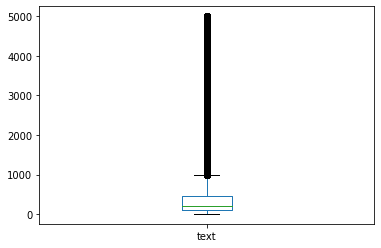

In [9]:
ax = df_nontoxic['text'].str.len().plot.box()
df_nontoxic['text'].str.len().describe()

The average length of toxic comments is 303 characters, non-toxic - 404. Comments with a length of 2000 to 5000 can be classified as outliers for both cases. That is, there are no significant differences for both groups of comments in terms of length.

In [10]:
df_toxic['length'] = df_toxic['text'].str.len()


/tmp/ipykernel_71/2995411153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toxic['length'] = df_toxic['text'].str.len()


Even from a short excerpt it is clear that toxic comments are typically written using CAPSLOCK and
repeated use of exclamation point. We will also remove comments that are too long - longer than the 0.95th quantile.

In [11]:
df_nontoxic['length'] = df_nontoxic['text'].str.len()

df = df[(df['text'].str.len())<(df_nontoxic['length'].quantile(0.95))]


/tmp/ipykernel_71/2622952063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nontoxic['length'] = df_nontoxic['text'].str.len()


In [12]:
del df_nontoxic
del df_toxic

Let's add the "is_upper" attribute, which is responsible for writing the comment in capital letters

In [13]:
df['is_upper']=df['text'].str.isupper().astype('int')
df.head(10)

,text,toxic,is_upper
0,Explanation\nWhy the edits made under my usern...,0,0
1,D'aww! He matches this background colour I'm s...,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0
4,"You, sir, are my hero. Any chance you remember...",0,0
5,"""\n\nCongratulations from me as well, use the ...",0,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1
7,Your vandalism to the Matt Shirvington article...,0,0
8,Sorry if the word 'nonsense' was offensive to ...,0,0
9,alignment on this subject and which are contra...,0,0


Cleaning text from unnecessary characters

In [14]:
#def cleaning(text):
#    text = re.sub(r"(?:\n|\r)", " ", text)
#    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
#    text = text.lower()
#    return text
#
#df['text'] = df['text'].apply(cleaning) 
#df.head(10)

Lemmatizing the text

In [15]:
#corpus = df['text']
#def lemmatize(text):
#    lemm = m.lemmatize(text)
#    return "".join(lemm)
#
#

Let's add the is_upper feature to the corpus as str.

In [16]:
is_upper = df['is_upper']

# Конкатенация текстов с учетом признака is_upper
#corpus = corpus + is_upper.astype(str)

In [17]:
#corpus.loc[0] = lemmatize(corpus.loc[0])


In [18]:
lemmatizer = WordNetLemmatizer()
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [19]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)



In [ ]:
# function for cleaning and lemmatizing text with marked parts of speech
def lemmatize_text(text):
    text = text.lower()
    reg = re.sub(r'[^a-zA-Z]', ' ', text)
    clear = reg.split() 
    
    lemm = []
    for i in range(len(clear)):
        lemm.append(lemmatizer.lemmatize(clear[i], get_wordnet_pos(clear[i])))
    return " ".join(lemm)

In [21]:
df['lemmatized_text'] = df['text'].apply(lemmatize_text)

In [22]:
df.head(5)

,text,toxic,is_upper,lemmatized_text
0,Explanation\nWhy the edits made under my usern...,0,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,0,you sir be my hero any chance you remember wha...


In [23]:
df['lemmatized_text']  = df['lemmatized_text']  + is_upper.astype(str)

Text is lemmatized

Loading stop words

In [24]:
stopwords = set(nltk_stopwords.words('english'))

The preparation of the text is completed.

**Conclusion from step 1**: Data received - comments on product descriptions of the online store. The initial analysis of the data revealed that the number of toxic comments is 10%, the length of toxic and non-toxic comments is approximately the same, however, there are many outliers, so comments longer than the 0.98th quantile were removed. It is also noticeable that toxic comments are often written with CAPSLOCK, so we added this feature to the comments.

Cleaning text from unnecessary characters

## Training

We form samples in the ratio 40-40-20:

In [25]:
target=df['toxic'].values
#features = df.drop('toxic', axis=1)
features = df['lemmatized_text']
f_valid, f_test, t_valid, t_test = train_test_split(features, target, test_size = .2, random_state = 42)
f_train, f_valid, t_train, t_valid = train_test_split(f_valid, t_valid, shuffle=False, test_size=0.5, random_state = 42)

f_train.shape[0], f_valid.shape[0], f_test.shape[0]

(60638, 60638, 30319)

Let's vectorize features using TfidfVectorizer

In [26]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

tfidf_train = count_tf_idf.fit_transform(f_train)
tfidf_valid = count_tf_idf.transform(f_valid)
tfidf_test = count_tf_idf.transform(f_test)


In [27]:
results_f1 =[]

Model Training
**1. Linear Regression**

In [28]:
best_result_LR=0
best_model= None
best_C= None
for c in range(1, 20,2):
    model = LogisticRegression(class_weight='balanced', 
                          random_state=12345, 
                          max_iter=1000, 
                          solver='lbfgs', 
                               C=c)
   
    model.fit(tfidf_train, t_train)
    
    predicted_valid = model.predict(tfidf_valid)
    result= f1_score(t_valid, predicted_valid)
    if result>best_result_LR:
        best_result_LR = result
        best_C= c
#print ("Значение С:", best_C)

print("Best F1_score:", best_result_LR, "Value С:", best_C)


Лучшее F1_score: 0.7542980494950273 Значение С: 11


In [29]:
results_f1.append(best_result_LR)

The best value f1= 0.754 for logistic regression was achieved with parameter C= 11.

**2. Random Forest **

Hyperparameters tuning:

In [30]:
best_result_RF = 0
best_model=None
best_depth = 0

for est in range(10,100,10):
    
    for depth in range(2, 26, 2):
        model = RandomForestClassifier(random_state=12345, 
                                       n_estimators= est,
                                       max_depth=depth,
                                       class_weight='balanced')
        #обучим модель
        model.fit(tfidf_train, t_train)
        predicted_valid = model.predict(tfidf_valid)
        result=f1_score(t_valid, predicted_valid)
        if result>best_result_RF:
            best_model=model
            best_result_RF = result
            best_depth= depth
            best_est = est
print('Depth:', best_depth, 'N of trees', best_est)
print("F1_score:", best_result_RF)    

Глубина: 24 Число деревьев 80
F1_score: 0.43041339891000924


In [31]:
results_f1.append(best_result_RF)

The best value f1= 0.43 for random forest was achieved with parameter depth= 24, n_estimators=80.

**3. CatBoost**

In [32]:
class_weights = [1, 9]
#cat_features = tfidf_train

In [35]:
%%capture

best_result_CB=0   

for rate in [0.01, 0.1]:    
    for depth in range(2, 6, 2):
        model = CatBoostClassifier(random_state=12345, 
                                   learning_rate = rate,                                       
                                   depth=depth,
                                   class_weights=class_weights,
                                   silent= True)
        
        model.fit(tfidf_train, t_train)
        predicted_valid = model.predict(tfidf_valid)
        result=f1_score(t_valid, predicted_valid)
        if result>best_result_CB:
            
            best_result_CB = result
            best_depth= depth
            best_learning_rate= rate


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [36]:
print('Глубина:', best_depth)
            
print('Скорость обучения:', best_learning_rate)
print("F1_score:", best_result_CB)    

Глубина: 4
Скорость обучения: 0.1
F1_score: 0.7260882440035534


In [37]:
results_f1.append(best_result_CB)

The best value f1= 0.72 for the CatBoost model was achieved with the parameter learning_rate= 0.1, depth=4.

Summary table for all models:

In [38]:

quality = pd.DataFrame({'model': [ 'LR', 'RF', 'CatBoost'], 'f1':results_f1 })
quality

,model,f1
0,LR,0.754298
1,RF,0.430413
2,CatBoost,0.726088


The best metric value was shown by the Logistic Regression model.

**Testing:**

Let's carry out testing with selected parameters.

In [39]:
model = LogisticRegression(class_weight='balanced', 
                          random_state=12345, 
                          max_iter=1000, 
                          solver='lbfgs',
                          C=19)

# обучим модель на тренировочной выборке
model.fit(tfidf_train, t_train)

# найдем предсказания на тестовой выборке
predicted_test = model.predict(tfidf_test)

# выведем результат F1
print("F1_score:", f1_score(t_test, predicted_test))

F1_score: 0.7629317080793874


The F1 metric on the test sample is 0.755, which satisfies the conditions of the problem.


## Conclusion

Data with comments was received, it was necessary to find the best model to determine the toxicity of comments. The data was analyzed - the extra column was removed, the lengths of toxic and non-toxic comments were analyzed. Next, the text was prepared for training - cleaning, lemmatization and vectorization using the Tfidf method.
Parameters were selected for three models - logistic regression, decision tree and CatBoost. The best F1 metric on the training set was shown by the logistic regression model; on the test set, the F1 metric = 0.763.